In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 35% 9.00M/25.7M [00:00<00:00, 94.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 175MB/s] 


In [5]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


# Dépendances

In [6]:
import pandas
import matplotlib.pyplot as plt
import numpy

from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')

from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Attention, Flatten, Dense

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Chargement du Dataset

In [7]:
df = pandas.read_csv('IMDB Dataset.csv')

# Fonction de Prétraitement

In [8]:
def preprocess_review(review):
  review = BeautifulSoup(review).get_text()
  review = re.sub("[^a-zA-Z]", " ", review)
  review = review.lower()

  review = review.split()
  stop_words = set(nltk.corpus.stopwords.words("english"))

  return " ".join([word for word in review if word not in stop_words])

In [9]:
reviews = df["review"].apply(preprocess_review)

<ipython-input-8-381431518874>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review).get_text()


# Label Encoding

In [10]:
le = LabelEncoder()
sentiments = le.fit_transform(df["sentiment"])

# Optimisation

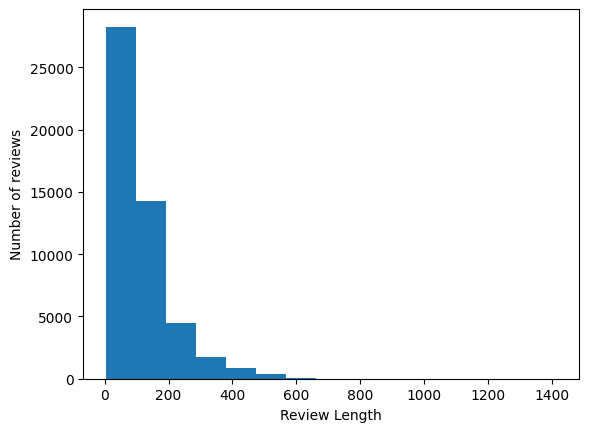

In [11]:
reviews_lengths = [len(review.split()) for review in reviews]

plt.hist(reviews_lengths, bins=15)
plt.xlabel("Review Length")
plt.ylabel("Number of reviews")
plt.show()

In [12]:
X, Y = [], []
for index, review in enumerate(reviews.values):
  if len(review.split()) < 400:
    X.append(review)
    Y.append(sentiments[index])

X, Y = numpy.array(X), numpy.array(Y)

In [13]:
len(X)

48958

# Tokenisation

In [14]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=400, padding="post")

In [15]:
X

array([[    3,  1803,   929, ...,     0,     0,     0],
       [  264,    41,   240, ...,     0,     0,     0],
       [   83,   264,    23, ...,     0,     0,     0],
       ...,
       [ 3181,  4267, 35810, ...,     0,     0,     0],
       [   70,  2761,   785, ...,     0,     0,     0],
       [    3,  5724,   207, ...,     0,     0,     0]], dtype=int32)

# Split Train Test

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2) # Stratify pour garder la meme proportion de classes dans train/test

# Callbacks

In [17]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [18]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,         # Lower bound on the learning rate
    verbose=1            # Print messages when the learning rate is reduced
)

# Essai avec Sequential en vain

In [19]:
#model_lstm = Sequential([
#    Embedding(input_dim=5000, output_dim=128, input_length=400),
#    LSTM(128, return_sequences=True),
#    Dropout(0.2),
#    LSTM(64),
#    Dropout(0.2),
#    Dense(1, activation='sigmoid')
#])
#model_lstm.compile(loss="binary_crossentropy", optimizer="adam",  metrics=["accuracy"])
#model_lstm.summary()

# Définition du Modèle

In [20]:
def lstm_model():
  input_layer = Input(shape=(400,))

  embedding_layer = Embedding(input_dim=80_000, output_dim=128)(input_layer)
  lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)
  attention_layer = Attention()([lstm_layer, lstm_layer])

  flatten_layer = Flatten()(attention_layer)

  output_layer = Dense(1, activation="sigmoid")(flatten_layer)

  model = Model(inputs=input_layer, outputs=output_layer)

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
  model.summary()
  return model

In [21]:
model_lstm = lstm_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 400, 128)             1024000   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 (None, 400, 128)             131584    ['embedding[0][0]']           
                                                                                                  
 attention (Attention)       (None, 400, 128)             0         ['lstm[0][0]',            

# Entrainement

In [22]:
history = model_lstm.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.15, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
521/521 [==============================] - 60s 108ms/step - loss: 0.3558 - accuracy: 0.8390 - val_loss: 0.2640 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 2/100
521/521 [==============================] - 34s 65ms/step - loss: 0.1574 - accuracy: 0.9408 - val_loss: 0.3127 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 3/100
521/521 [==============================] - 27s 52ms/step - loss: 0.0770 - accuracy: 0.9721 - val_loss: 0.4183 - val_accuracy: 0.8834 - lr: 0.0010
Epoch 4/100
521/521 [==============================] - 23s 45ms/step - loss: 0.0429 - accuracy: 0.9852 - val_loss: 0.6166 - val_accuracy: 0.8761 - lr: 0.0010
Epoch 5/100
521/521 [==============================] - 21s 40ms/step - loss: 0.0264 - accuracy: 0.9907 - val_loss: 0.7969 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 6/100
521/521 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9931
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
521/521 [==========================

# Résultats

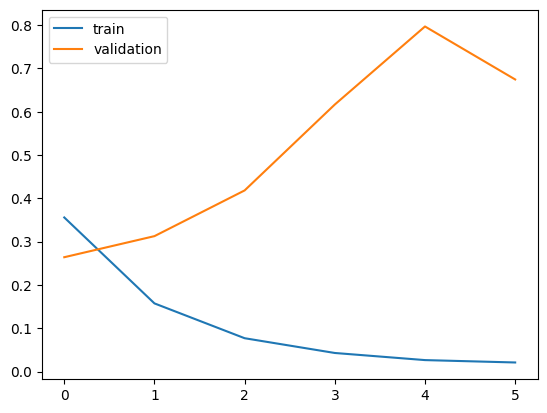

In [23]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

In [24]:
predictions = model_lstm.predict(x_test)

# Arrondir les prédictions
predictions_binary = (predictions > 0.5).astype(int)

accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)
roc_auc = roc_auc_score(y_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

306/306 [==============================] - 4s 10ms/step
Accuracy: 0.8935866013071896
Precision: 0.8703953712632594
Recall: 0.924226909686668
F1 Score: 0.8965037743345253
ROC AUC Score: 0.9584711459811661


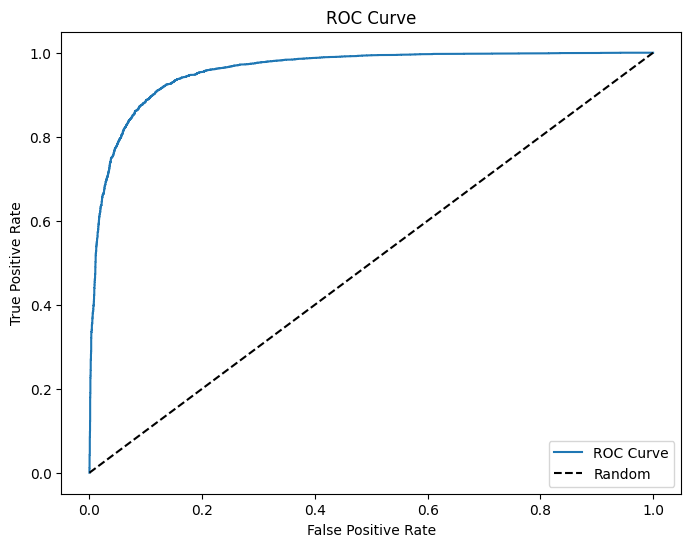

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [26]:
best_threshold = None
best_f1 = 0

# Recherche du seuil optimal
for threshold in thresholds:
    f1 = f1_score(y_test, predictions > threshold)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1)

Best Threshold: 0.50127596
Best F1 Score: 0.8966613672496025
